In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid,KFold

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load data

In [4]:
DIR  = "/gdrive/MyDrive/Data_Science_Projekte/earth_quake_damage_dd/"

train_values = pd.read_csv(DIR+'data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DIR+'data/train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DIR+"data/test_values.csv", index_col='building_id')
submission_format = pd.read_csv(DIR+"data/submission_format.csv", index_col='building_id')

train_data = train_values.join(train_labels)
train_data.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


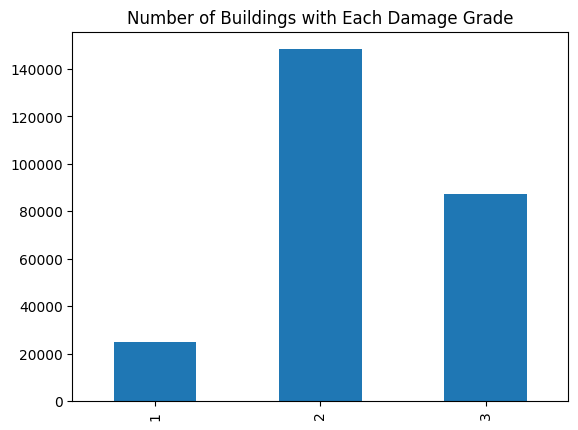

In [5]:
(train_labels.damage_grade.value_counts().sort_index()
    .plot.bar(title="Number of Buildings with Each Damage Grade"))
plt.show()

In [6]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

# Geo Embedding

In [7]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [8]:
# Step 1: Label Encoding
from sklearn.preprocessing import LabelEncoder

X = pd.concat([train_values, test_values]).loc[:,geo_features].drop_duplicates()

label_encoders = {}
encoded_data = {}

for column in X.columns:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(X[column])
    label_encoders[column] = le

encoded_df = pd.DataFrame(encoded_data)

input_data = torch.tensor(encoded_df.values, dtype=torch.long)
output_data = input_data.clone()

In [9]:
# Step 2: Define the Neural Network
class GeoEncoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=16,
                 num_classes1: int=31,
                 num_classes2: int=1428,
                 num_classes3: int=12568):
        super().__init__()
        self.geo_lv1_embedder = nn.Embedding(num_classes1, 16)
        self.geo_lv2_embedder = nn.Embedding(num_classes2, 512)
        self.geo_lv3_embedder = nn.Embedding(num_classes3, 1024)
        self.compressor = torch.nn.Linear(16+512+1024, emb_dim)

    def forward(self, x):
        x_1 = self.geo_lv1_embedder(x[:, 0])
        x_2 = self.geo_lv2_embedder(x[:, 1])
        x_3 = self.geo_lv3_embedder(x[:, 2])
        x = torch.concat((x_1, x_2, x_3), dim=1)
        x = torch.nn.functional.relu(x)
        return self.compressor(x)

class GeoDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=16,
                 num_classes1: int=31,
                 num_classes2: int=1428,
                 num_classes3: int=12568):
        super().__init__()
        self.geo_lv1_predictor = nn.Linear(emb_dim, num_classes1)
        self.geo_lv2_predictor = nn.Linear(emb_dim, num_classes2)
        self.geo_lv3_predictor = nn.Linear(emb_dim, num_classes3)

    def forward(self, x):
        x1 = self.geo_lv1_predictor(x)
        x2 = self.geo_lv2_predictor(x)
        x3 = self.geo_lv3_predictor(x)
        return x1, x2, x3

class GeoEncoderDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=16,
                 num_classes1: int=31,
                 num_classes2: int=1428,
                 num_classes3: int=12568):
        super().__init__()
        self.encoder = GeoEncoderModel(emb_dim, num_classes1, num_classes2, num_classes3)
        self.decoder = GeoDecoderModel(emb_dim, num_classes1, num_classes2, num_classes3)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.relu(x)
        x1, x2, x3 = self.decoder(x)
        return x1, x2, x3

In [10]:
# Step 3: Training

# Create the neural network model
model = GeoEncoderDecoderModel().to(DEVICE)

batch_size = 512  # You can adjust this based on your available memory and computational resources
dataset = TensorDataset(input_data, output_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 400  # You can adjust this based on your data size and convergence
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = 0
        for i in range(3):
          loss += criterion(outputs[i], targets[:,i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if ((epoch % 10 == 0) or (epoch == num_epochs -1)):
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.6f}")


Epoch [1/400], Loss: 20.181284
Epoch [11/400], Loss: 17.114764
Epoch [21/400], Loss: 12.612478
Epoch [31/400], Loss: 9.529880
Epoch [41/400], Loss: 7.681048
Epoch [51/400], Loss: 6.423208
Epoch [61/400], Loss: 5.496152
Epoch [71/400], Loss: 4.807351
Epoch [81/400], Loss: 4.214793
Epoch [91/400], Loss: 3.774282
Epoch [101/400], Loss: 3.402312
Epoch [111/400], Loss: 3.084507
Epoch [121/400], Loss: 2.822442
Epoch [131/400], Loss: 2.611599
Epoch [141/400], Loss: 2.409006
Epoch [151/400], Loss: 2.253303
Epoch [161/400], Loss: 2.092033
Epoch [171/400], Loss: 1.980423
Epoch [181/400], Loss: 1.864987
Epoch [191/400], Loss: 1.790918
Epoch [201/400], Loss: 1.693244
Epoch [211/400], Loss: 1.630206
Epoch [221/400], Loss: 1.567422
Epoch [231/400], Loss: 1.492393
Epoch [241/400], Loss: 1.452201
Epoch [251/400], Loss: 1.351341
Epoch [261/400], Loss: 1.331172
Epoch [271/400], Loss: 1.326280
Epoch [281/400], Loss: 1.265688
Epoch [291/400], Loss: 1.207420
Epoch [301/400], Loss: 1.195877
Epoch [311/400],

In [11]:
# Step 4: Extract the Embedding
# Now that the model is trained, you can get the embeddings for your original data

for df in [train_values, test_values]:
    encoded_data = {}

    for column in geo_features:
        le = label_encoders[column]
        encoded_data[column] = le.transform(df[column])

    encoded_df = pd.DataFrame(encoded_data)

    input_data = torch.tensor(encoded_df.values, dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        embedding = torch.relu(model.encoder(input_data))

    embedding = np.array(embedding.to('cpu'))

    for j in range(16):
        df ['geo_' + str(j+1)] = embedding[:,j]

    df.drop(columns=geo_features, inplace=True) #check if really deleted and if we want this

In [12]:
train_values.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,geo_7,geo_8,geo_9,geo_10,geo_11,geo_12,geo_13,geo_14,geo_15,geo_16
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,30,6,5,t,r,n,f,q,t,...,163.482300,0.0,0.0,0.0,181.078857,295.450043,0.0,149.304108,456.179688,0.0
28830,2,10,8,7,o,r,n,x,q,s,...,340.377533,0.0,0.0,0.0,348.856140,169.112961,0.0,250.821701,23.835806,0.0
94947,2,10,5,5,t,r,n,f,x,t,...,134.289413,0.0,0.0,0.0,224.580261,384.342651,0.0,328.409729,46.926170,0.0
590882,2,10,6,5,t,r,n,f,x,s,...,115.152481,0.0,0.0,0.0,223.415253,391.969910,0.0,224.822006,239.291702,0.0
201944,3,30,8,9,t,r,n,f,x,s,...,418.992920,0.0,0.0,0.0,8.457445,52.768101,0.0,126.111961,291.441071,0.0


In [ ]:
#torch.save(model.encoder.state_dict(), DIR + 'dim-reduction-16-large-w.pt')

# Search for best hyperparameters

In [21]:
param_grid = {'objective': ['multi:softmax'],
              'random_state': [42],
              'n_estimators': [300, 400],
              'learning_rate': [0.08, 0.1],
              'max_depth': [12, 14],
              'min_child_weight':[50],
              'min_split_loss': [0],
              'colsample_bytree': [0.75, 0.8]
}

param_list = list(ParameterGrid(param_grid))

print('Size of ParameterGrid: ', len(param_list))

Size of ParameterGrid:  16


In [22]:
X = pd.get_dummies(train_values)
y = train_labels.values.ravel() - 1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

best_score = 0
results = []

f = IntProgress(min=0, max=len(param_list)) #progress bar
display(f)

for i, params in enumerate(param_list):
    if DEVICE == "cuda":
        xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
    else:
        xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)

    df = pd.DataFrame(data=params, index = [i])

    pred_y_train = xgb_model.predict(X_train)
    train_score = f1_score(y_train, pred_y_train, average='micro')
    df['train_score'] = train_score

    pred_y_val = xgb_model.predict(X_val)
    val_score = f1_score(y_val, pred_y_val, average='micro')
    df['val_score'] = val_score

    results.append(df)

    if val_score > best_score:
        best_score = val_score
        best_model = xgb_model
        best_params = params

    f.value += 1

IntProgress(value=0, max=16)

In [24]:
print('best parameter:', best_params)
print('best val score:', best_score)

best parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 50, 'min_split_loss': 0, 'n_estimators': 400, 'objective': 'multi:softmax', 'random_state': 42}
best val score: 0.7479135089503273


In [25]:
df_results = pd.concat(results).drop(columns=['objective', 'random_state'])
df_results.sort_values(by='val_score',ascending=False).head(10)

,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_loss,n_estimators,train_score,val_score
13,0.80,0.10,12,50,0,400,0.809924,0.747914
11,0.80,0.08,14,50,0,400,0.815392,0.747875
10,0.80,0.08,14,50,0,300,0.805713,0.747702
14,0.80,0.10,14,50,0,300,0.812606,0.747530
15,0.80,0.10,14,50,0,400,0.822784,0.747415
3,0.75,0.08,14,50,0,400,0.815090,0.747089
9,0.80,0.08,12,50,0,400,0.803391,0.747069
5,0.75,0.10,12,50,0,400,0.809531,0.747012
12,0.80,0.10,12,50,0,300,0.800221,0.746782
1,0.75,0.08,12,50,0,400,0.802700,0.746666


<Axes: >

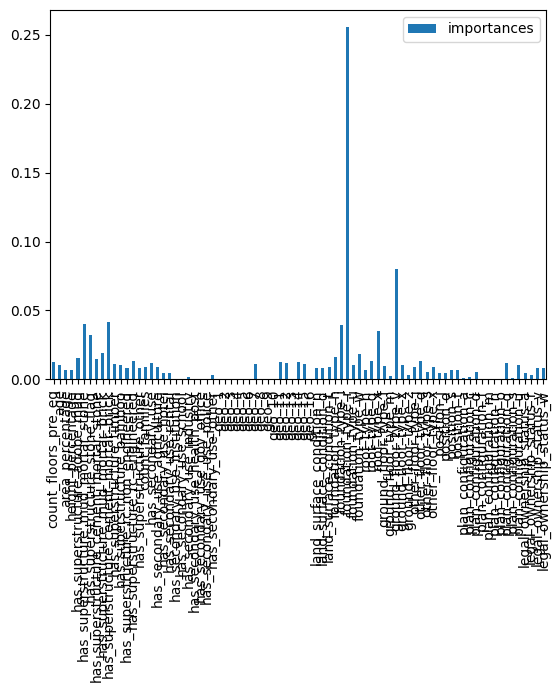

In [26]:
#get feature importances and graph, could look further into thesee to improve the model further
df_importances=pd.DataFrame(best_model.feature_importances_)
df_importances.index=X.columns
df_importances.columns=['importances']
df_importances.plot.bar()

In [ ]:
important_features = df_importances.sort_values(by='importances', ascending=False).iloc[:].index

In [ ]:
X = pd.get_dummies(train_values).loc[:, important_features]
y = train_labels.values.ravel() - 1

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_scores = []
val_scores = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    if DEVICE == "cuda":
      xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',**best_params)
    else:
      xgb_model = xgb.XGBClassifier(**best_params)
    xgb_model.fit(X_train, y_train)

    train_y_pred = xgb_model.predict(X_train)
    train_scores.append(f1_score(y_train, train_y_pred, average='micro'))

    val_y_pred = xgb_model.predict(X_test)
    val_scores.append(f1_score(y_test, val_y_pred, average='micro'))

print('training score: {0: .5f}'.format(np.mean(train_scores)))
print('validation score: {0: .5f}'.format(np.mean(val_scores)))

training score:  0.80990
validation score:  0.74721


# Final training and prediction

In [36]:
X_train = pd.get_dummies(train_values).loc[:, important_features]
X_test = pd.get_dummies(test_values).loc[:, important_features]
y_train = train_labels.values.ravel() - 1

if DEVICE == "cuda":
    xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',**best_params)
else:
    xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

pred_y_train = xgb_model.predict(X_train)
train_score = f1_score(y_train, pred_y_train, average='micro')
print('training score: {0: .4f}'.format(train_score))

training score:  0.8075


In [37]:
predictions = xgb_model.predict(X_test) + 1

# Save submission

In [38]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [39]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [40]:
my_submission.to_csv(DIR+'submissions/submission_first.csv')